In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nachiketkamod/weather-dataset-us")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'weather-dataset-us' dataset.
Path to dataset files: /kaggle/input/weather-dataset-us


In [ ]:
import pandas as pd
import os
if os.path.isfile('/kaggle/input/weather-dataset-us/Weather Data (US).csv'):
  weather_df = pd.read_csv('/kaggle/input/weather-dataset-us/Weather Data (US).csv')
else:
    weather_df = pd.read_csv('/root/.cache/kagglehub/datasets/nachiketkamod/weather-dataset-us/versions/1/Weather Data (US).csv')
weather_df["DATE"] = pd.to_datetime(weather_df["DATE"])
weather_df["YEAR"] = weather_df["DATE"].dt.year

# Filter weather data to 2005–2020
weather_df = weather_df[
    (weather_df["YEAR"] >= 2005) & (weather_df["YEAR"] <= 2020)
]

print("Weather years used:", weather_df["YEAR"].unique())

Weather years used: [2007 2015 2011 2012 2018 2008 2016 2020 2013 2005 2019 2009 2017 2006
 2014]


In [ ]:
pip install geopandas shapely

In [ ]:
pip install geopandas shapely pyproj


In [ ]:
stations_df = weather_df[["ID", "Latitude", "Longitude"]].drop_duplicates()

print("Unique stations:", stations_df.shape[0])

Unique stations: 52622


replace us_states/cb_2020_us_state_5m.shp.ea.iso.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
            ID STATE
0  US1OKCV0021    OK
1  US1MDHW0012    MD
2  USR0000AGOP    AK
3  USC00201675    MI
4  USC00230657    MO


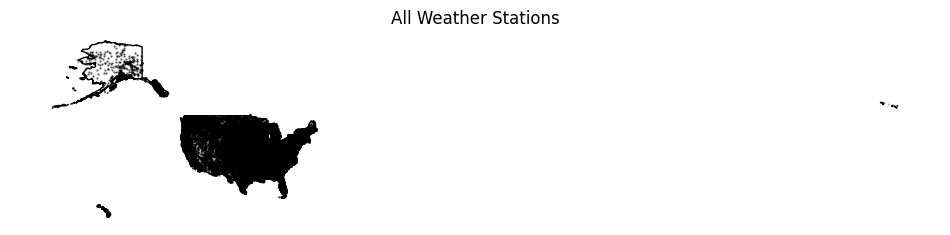

In [ ]:
import geopandas as gpd

!wget -q https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_5m.zip
!unzip -q cb_2020_us_state_5m.zip -d us_states

states = gpd.read_file("us_states/cb_2020_us_state_5m.shp")

states = states[~states["STUSPS"].isin(["PR", "GU", "VI", "MP", "AS"])]
states = states[["STUSPS", "geometry"]].rename(columns={"STUSPS": "STATE"})
states = states.to_crs("EPSG:4326")

stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(
        stations_df["Longitude"],
        stations_df["Latitude"]
    ),
    crs="EPSG:4326"
)

stations_with_state = gpd.sjoin(
    stations_gdf,
    states,
    how="left",
    predicate="within"
)[["ID", "STATE"]]

weather_df = weather_df.drop(
    columns=[c for c in weather_df.columns if c.startswith("STATE")],
    errors="ignore"
)

weather_df = weather_df.merge(
    stations_with_state,
    on="ID",
    how="left"
)

ax = states.plot(
    figsize=(12, 8),
    edgecolor="black",
    facecolor="none"
)

stations_gdf.plot(
    ax=ax,
    color="black",
    markersize=0.5,
    alpha=0.5
)

ax.set_title("All Weather Stations")
ax.axis("off")

# print("Missing state assignments:", weather_df["STATE"].isna().sum())
print(weather_df[["ID", "STATE"]].head())


In [ ]:
weather_df["TMAX_C"] = weather_df["TMAX"] / 10
weather_df["TMIN_C"] = weather_df["TMIN"] / 10
weather_df["TAVG_C"] = (weather_df["TMAX_C"] + weather_df["TMIN_C"]) / 2

weather_agg = weather_df.groupby(["STATE", "YEAR"]).agg(
    AVG_TEMP=("TAVG_C", "mean"),
    MAX_TEMP=("TMAX_C", "mean"),
    MIN_TEMP=("TMIN_C", "mean"),
    TOTAL_PRCP=("PRCP", "sum")
).reset_index()

print(weather_agg.head())

  STATE  YEAR  AVG_TEMP  MAX_TEMP  MIN_TEMP  TOTAL_PRCP
0    AK  2005  1.001470  5.652443 -3.646971   2105158.0
1    AK  2006 -0.365705  4.144809 -4.862522   2230989.0
2    AK  2007  0.185766  4.871255 -4.439427   2011022.0
3    AK  2008 -1.292745  3.095112 -5.677808   2279838.0
4    AK  2009 -0.159139  4.494942 -4.807412   2103252.0


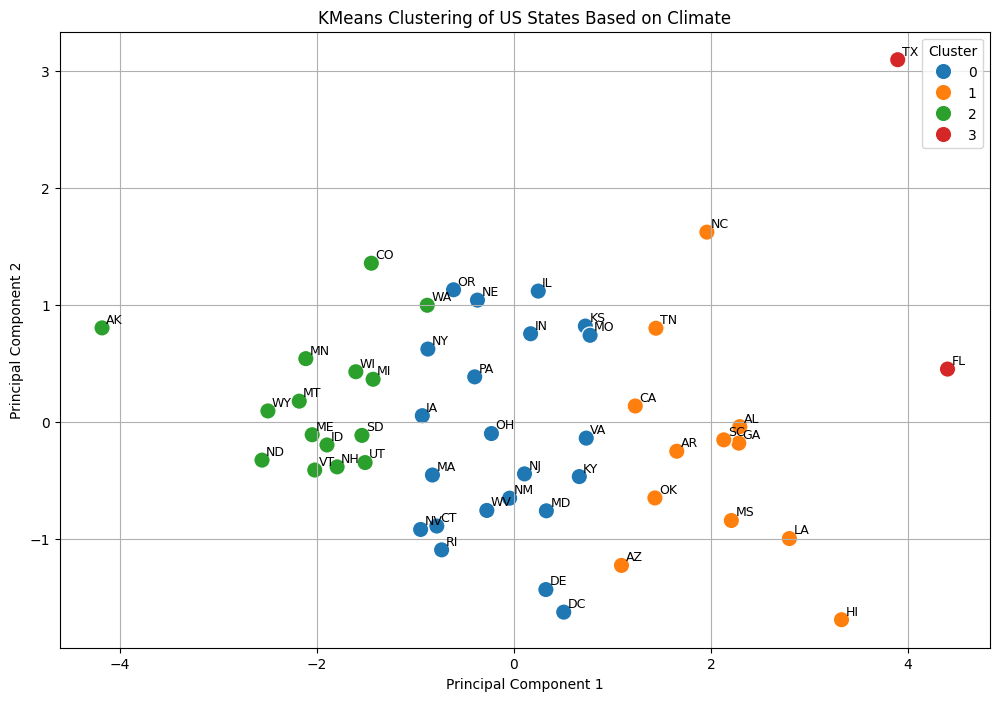

          AVG_TEMP   MAX_TEMP   MIN_TEMP     TOTAL_PRCP
CLUSTER                                                
0        11.450796  17.375601   5.525596  253474.244697
1        17.082277  23.275843  10.890974  352453.559259
2         6.270852  12.321939   0.219118  202943.554074
3        21.046936  27.076273  15.017083  885909.055556


In [ ]:
# State-Level Climate Clustering
# KMeans + PCA Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

weather_df["TMAX_C"] = weather_df["TMAX"] / 10
weather_df["TMIN_C"] = weather_df["TMIN"] / 10
weather_df["TAVG_C"] = (weather_df["TMAX_C"] + weather_df["TMIN_C"]) / 2

weather_df["YEAR"] = pd.to_datetime(weather_df["DATE"]).dt.year
weather_df["MONTH"] = pd.to_datetime(weather_df["DATE"]).dt.month

weather_agg = weather_df.groupby(["STATE", "YEAR", "MONTH"]).agg(
    AVG_TEMP=("TAVG_C", "mean"),
    MAX_TEMP=("TMAX_C", "mean"),
    MIN_TEMP=("TMIN_C", "mean"),
    TOTAL_PRCP=("PRCP", "sum")
).reset_index()

state_climate = weather_agg.groupby("STATE").agg(
    AVG_TEMP=("AVG_TEMP", "mean"),
    MAX_TEMP=("MAX_TEMP", "mean"),
    MIN_TEMP=("MIN_TEMP", "mean"),
    TOTAL_PRCP=("TOTAL_PRCP", "mean")
).reset_index()

features = ["AVG_TEMP", "MAX_TEMP", "MIN_TEMP", "TOTAL_PRCP"]
X = state_climate[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
state_climate["CLUSTER"] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

state_climate["PC1"] = X_pca[:, 0]
state_climate["PC2"] = X_pca[:, 1]

plt.figure(figsize=(12,8))

sns.scatterplot(
    data=state_climate,
    x="PC1",
    y="PC2",
    hue="CLUSTER",
    palette="tab10",
    s=140
)

for _, row in state_climate.iterrows():
    plt.text(row["PC1"] + 0.04, row["PC2"] + 0.04, row["STATE"], fontsize=9)

plt.title("KMeans Clustering of US States Based on Climate")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

cluster_summary = state_climate.groupby("CLUSTER")[features].mean()
print(cluster_summary)


In [ ]:
STATE_TO_REGION = {
    # Northeast
    "CT": "Northeast", "ME": "Northeast", "MA": "Northeast",
    "NH": "Northeast", "RI": "Northeast", "VT": "Northeast",
    "NJ": "Northeast", "NY": "Northeast", "PA": "Northeast",

    # Midwest
    "IL": "Midwest", "IN": "Midwest", "MI": "Midwest", "OH": "Midwest", "WI": "Midwest",
    "IA": "Midwest", "KS": "Midwest", "MN": "Midwest", "MO": "Midwest",
    "NE": "Midwest", "ND": "Midwest", "SD": "Midwest",

    # South
    "DE": "South", "FL": "South", "GA": "South", "MD": "South", "NC": "South",
    "SC": "South", "VA": "South", "WV": "South",
    "AL": "South", "KY": "South", "MS": "South", "TN": "South",
    "AR": "South", "LA": "South", "OK": "South", "TX": "South",

    # West
    "AZ": "West", "CO": "West", "ID": "West", "MT": "West", "NV": "West",
    "NM": "West", "UT": "West", "WY": "West",
    "AK": "West", "CA": "West", "HI": "West", "OR": "West", "WA": "West"
}

# Map STATE to Census REGION
weather_df["REGION"] = weather_df["STATE"].map(STATE_TO_REGION)

weather_df = weather_df.dropna(subset=["REGION"])

print(weather_df["REGION"].value_counts())
print(weather_df.head())

weather_df["DATE"] = pd.to_datetime(weather_df["DATE"])
weather_df["YEAR"] = weather_df["DATE"].dt.year

# years available in EIA CSVs
eia_years = [2005, 2009, 2015, 2020]
weather_df = weather_df[weather_df["YEAR"].isin(eia_years)]

weather_df["TMAX_C"] = weather_df["TMAX"] / 10
weather_df["TMIN_C"] = weather_df["TMIN"] / 10
weather_df["TAVG_C"] = (weather_df["TMAX_C"] + weather_df["TMIN_C"]) / 2

# Aggregate
weather_region_agg = weather_df.groupby(["REGION", "YEAR"]).agg(
    AVG_TEMP=("TAVG_C", "mean"),
    MAX_TEMP=("TMAX_C", "mean"),
    MIN_TEMP=("TMIN_C", "mean"),
    TOTAL_PRCP=("PRCP", "sum")
).reset_index()

print(weather_region_agg.head())

# eia_dfs = []

# for year in eia_years:
#     df = pd.read_csv(f"/{year}.csv", header=None)
#     print('New dataset columns:', df.iloc[:, :12].head())

#     # Find Census Region rows
#     region_rows = df[df[0].isin(["Northeast", "Midwest", "South", "West"])].copy()

#     region_rows.columns = [
#         "REGION",
#         "HOUSEHOLDS_MILLION",
#         "TOTAL_SITE_ENERGY_TRILLION_BTU",
#         "PER_HH_MBTU",
#         "PER_MEMBER_MBTU",
#         "PER_SQFT_KBTU",
#         "TOTAL_EXPENDITURE_BILLION",
#         "PER_HH_DOLLARS",
#         "PER_MEMBER_DOLLARS",
#         "PER_SQFT_DOLLARS"
#     ]

#     region_rows["YEAR"] = year
#     eia_dfs.append(region_rows)

REGION
West         35502352
South        31884398
Midwest      26544082
Northeast     7940849
Name: count, dtype: int64
            ID       DATE   TMAX   TMIN  EVAP   PRCP  Latitude  Longitude  \
0  US1OKCV0021 2007-04-18    NaN    NaN   NaN  241.0   35.1715   -97.4262   
1  US1MDHW0012 2015-10-14    NaN    NaN   NaN    0.0   39.3387   -76.9468   
2  USR0000AGOP 2011-03-07  -28.0 -200.0   NaN    NaN   64.2381  -145.2669   
3  USC00201675 2012-09-26  200.0  100.0   NaN    0.0   41.9622   -84.9925   
4  USC00230657 2007-05-10  267.0  139.0   NaN    3.0   37.0539   -93.5756   

   Elevation  YEAR STATE  TMAX_C  TMIN_C  TAVG_C  MONTH   REGION  
0      355.1  2007    OK     NaN     NaN     NaN      4    South  
1      166.1  2015    MD     NaN     NaN     NaN     10    South  
2      463.3  2011    AK    -2.8   -20.0   -11.4      3     West  
3      299.9  2012    MI    20.0    10.0    15.0      9  Midwest  
4      399.3  2007    MO    26.7    13.9    20.3      5  Midwest  
      REGION  

In [ ]:
import pandas as pd

# Years you have EIA CSVs for
EIA_YEARS = [2005, 2009, 2015, 2020]

# Census regions present in EIA tables
REGIONS = ["Northeast", "Midwest", "South", "West"]

eia_dfs = []

for year in EIA_YEARS:
    df = pd.read_csv(f"/content/{year}.csv", header=None, encoding="cp1252")

    # Keep only rows where column 0 is a Census region
    region_rows = df[df[0].isin(REGIONS)].copy()

    # Select only meaningful columns (based on RECS structure)
    region_rows = region_rows.iloc[:, [0, 1, 4, 5, 8]]

    # Rename columns cleanly
    region_rows.columns = [
        "REGION",
        "HOUSEHOLDS_MILLION",
        "TOTAL_SITE_ENERGY_QUAD_BTU",
        "ENERGY_PER_HH_MBTU",
        "TOTAL_EXPENDITURE_BILLION"
    ]

    # Add year
    region_rows["YEAR"] = year

    eia_dfs.append(region_rows)

# Combine all years into one dataframe
eia_region_df = pd.concat(eia_dfs, ignore_index=True)

print(eia_region_df)


       REGION HOUSEHOLDS_MILLION TOTAL_SITE_ENERGY_QUAD_BTU  \
0   Northeast               20.6                       2.52   
1     Midwest               25.6                       2.91   
2       South               40.7                       3.25   
3        West               24.2                       1.87   
4   Northeast               20.8                       42.4   
5     Midwest               25.9                       45.1   
6       South               42.1                       30.0   
7        West               24.8                       26.9   
8   Northeast               21.0                       38.1   
9     Midwest               26.4                       37.8   
10      South               44.4                       27.3   
11       West               26.4                       22.3   
12  Northeast              21.92                       36.8   
13    Midwest              27.04                       40.9   
14      South              46.84                       

In [ ]:
import pandas as pd

combined_df = pd.merge(
    weather_region_agg,
    eia_region_df,
    on=["REGION", "YEAR"],
    how="inner"
)

print(combined_df)

       REGION  YEAR   AVG_TEMP   MAX_TEMP   MIN_TEMP   TOTAL_PRCP  \
0     Midwest  2005   9.816376  15.915360   3.716562   21914690.0   
1     Midwest  2009   8.211020  14.102508   2.323742   46987302.0   
2     Midwest  2015   9.689005  15.715528   3.663923   56672793.0   
3     Midwest  2020   9.583826  15.579288   3.594600   53294829.0   
4   Northeast  2005   8.852088  14.492492   3.216023    9607962.0   
5   Northeast  2009   8.175616  13.638296   2.715462   14844495.0   
6   Northeast  2015   8.707966  14.585640   2.827322   16844356.0   
7   Northeast  2020   9.774768  15.309119   4.248129   23369765.0   
8       South  2005  17.038743  23.283127  10.795688   27106231.0   
9       South  2009  16.685558  22.752950  10.620261   78728664.0   
10      South  2015  17.428225  23.370338  11.486265  101387166.0   
11      South  2020  17.460885  23.441858  11.478217  106484389.0   
12       West  2005   9.418444  16.052396   2.789334   26601472.0   
13       West  2009   8.582772  15

Predicted values for 2025 and 2030:
      REGION  AVG_TEMP_2025  AVG_TEMP_2030  MAX_TEMP_2025  MAX_TEMP_2030  \
0    Midwest       9.623925       9.741129      15.595133      15.699824   
1  Northeast       9.750652      10.093021      15.419233      15.777212   
2      South      17.688758      17.898721      23.523438      23.645544   
3       West       9.073891       9.048041      15.655544      15.619745   

   MIN_TEMP_2025  MIN_TEMP_2030  TOTAL_PRCP_2025  TOTAL_PRCP_2030  \
0       3.659835       3.791257     6.980734e+07     7.964654e+07   
1       4.086136       4.413353     2.684791e+07     3.103664e+07   
2      11.851704      12.148408     1.419748e+08     1.668957e+08   
3       2.492224       2.473832     4.265945e+07     4.607732e+07   

   TOTAL_SITE_ENERGY_QUAD_BTU_2025  TOTAL_SITE_ENERGY_QUAD_BTU_2030  \
0                       130.520592                       266.093988   
1                       126.377946                       262.089916   
2                       

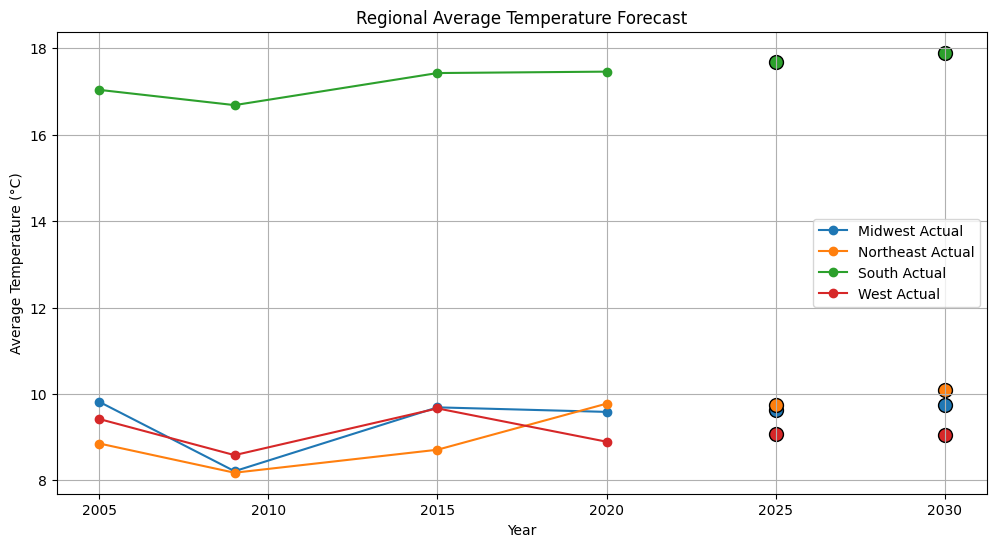

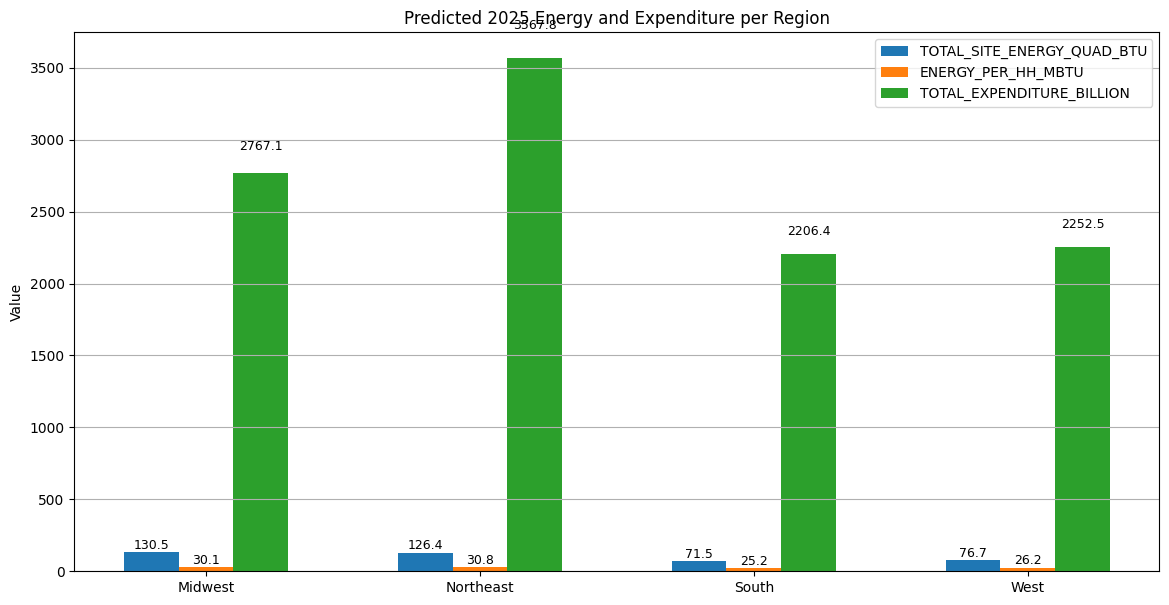

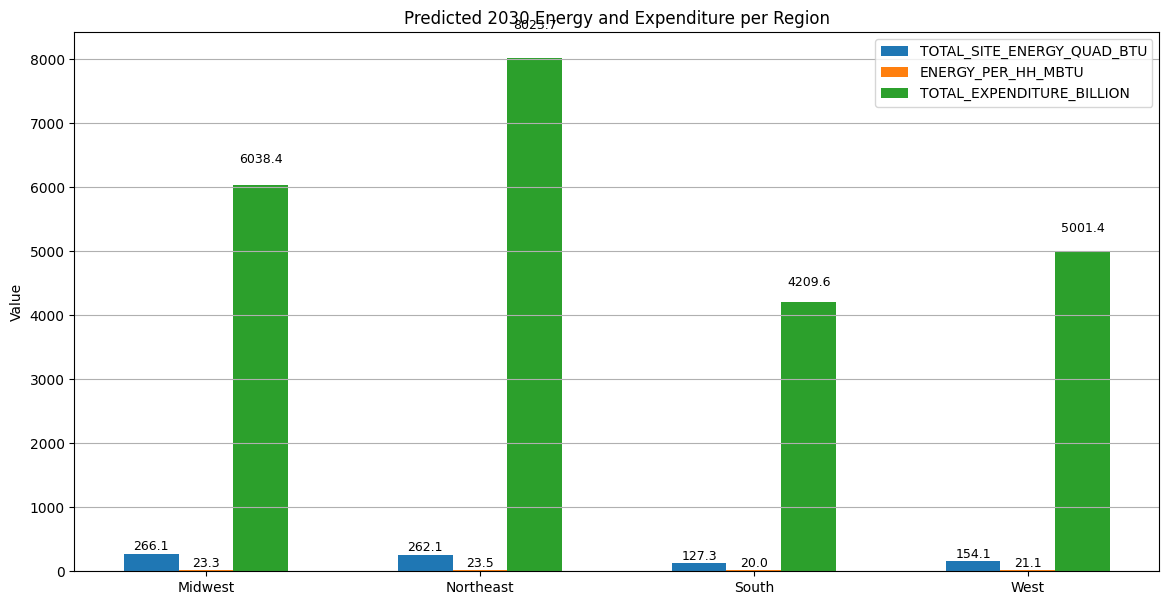

In [ ]:
#Regression for future data prediction

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

combined_df = combined_df.copy()

combined_df['TOTAL_EXPENDITURE_BILLION'] = (
    combined_df['TOTAL_EXPENDITURE_BILLION']
    .replace(',', '', regex=True)
    .astype(float)
)

columns_to_predict = [
    "AVG_TEMP", "MAX_TEMP", "MIN_TEMP", "TOTAL_PRCP",
    "TOTAL_SITE_ENERGY_QUAD_BTU",
    "ENERGY_PER_HH_MBTU",
    "TOTAL_EXPENDITURE_BILLION"
]

log_transform_cols = [
    "TOTAL_SITE_ENERGY_QUAD_BTU",
    "ENERGY_PER_HH_MBTU",
    "TOTAL_EXPENDITURE_BILLION"
]

future_years = [2025, 2030]
predictions = []

for region in combined_df['REGION'].unique():
    region_df = combined_df[combined_df['REGION'] == region]
    X = region_df[['YEAR']].values

    region_preds = {"REGION": region}

    for col in columns_to_predict:
        y = pd.to_numeric(region_df[col], errors='coerce').values

        model = LinearRegression()

        if col in log_transform_cols:
            y_log = np.log(y)
            model.fit(X, y_log)

            for year in future_years:
                pred_log = model.predict([[year]])[0]
                pred = np.exp(pred_log)
                region_preds[f"{col}_{year}"] = pred
        else:
            model.fit(X, y)
            for year in future_years:
                pred = model.predict([[year]])[0]
                region_preds[f"{col}_{year}"] = pred

    predictions.append(region_preds)

pred_df = pd.DataFrame(predictions)

print("Predicted values for 2025 and 2030:")
print(pred_df)

colors = plt.cm.tab10.colors
region_colors = {region: colors[i] for i, region in enumerate(combined_df['REGION'].unique())}

plt.figure(figsize=(12,6))
for i, region in enumerate(combined_df['REGION'].unique()):
    region_df = combined_df[combined_df['REGION'] == region]
    plt.plot(region_df['YEAR'], region_df['AVG_TEMP'], marker='o', color=region_colors[region], label=f"{region} Actual")
    for year in future_years:
        plt.scatter(year, pred_df.loc[pred_df['REGION']==region, f'AVG_TEMP_{year}'], color=region_colors[region], s=100, edgecolor='black')

plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.title("Regional Average Temperature Forecast")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,7))
bar_width = 0.2
x = np.arange(len(combined_df['REGION'].unique()))

bars_list = []
for i, col in enumerate(["TOTAL_SITE_ENERGY_QUAD_BTU", "ENERGY_PER_HH_MBTU", "TOTAL_EXPENDITURE_BILLION"]):
    values = []
    for region in combined_df['REGION'].unique():
        values.append(pred_df.loc[pred_df['REGION']==region, f"{col}_2025"].values[0])
    bars = plt.bar(x + i*bar_width, values, width=bar_width, label=col)
    bars_list.append(bars)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05*height, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.xticks(x + bar_width, combined_df['REGION'].unique())
plt.ylabel("Value")
plt.title("Predicted 2025 Energy and Expenditure per Region")
plt.legend()
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(14,7))
bar_width = 0.2
x = np.arange(len(combined_df['REGION'].unique()))
bars_list = []
for i, col in enumerate(["TOTAL_SITE_ENERGY_QUAD_BTU", "ENERGY_PER_HH_MBTU", "TOTAL_EXPENDITURE_BILLION"]):
    values = []
    for region in combined_df['REGION'].unique():
        values.append(pred_df.loc[pred_df['REGION']==region, f"{col}_2030"].values[0])
    bars = plt.bar(x + i*bar_width, values, width=bar_width, label=col)
    bars_list.append(bars)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05*height, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.xticks(x + bar_width, combined_df['REGION'].unique())
plt.ylabel("Value")
plt.title("Predicted 2030 Energy and Expenditure per Region")
plt.legend()
plt.grid(axis='y')
plt.show()

             ID       DATE   TMAX   TMIN  EVAP  PRCP  Latitude  Longitude  \
1   US1MDHW0012 2015-10-14    NaN    NaN   NaN   0.0   39.3387   -76.9468   
10  US1TNDV0152 2020-01-29    NaN    NaN   NaN   0.0   36.1124   -86.8117   
15  USC00046940 2005-10-25    NaN    NaN   NaN  13.0   34.4061  -118.7569   
17  USC00358260 2005-12-14    NaN    NaN   NaN   0.0   43.3964  -123.3600   
18  USC00324203 2009-06-23  278.0  194.0   NaN   0.0   47.4389   -97.0664   

    Elevation  YEAR STATE  TMAX_C  TMIN_C  TAVG_C  MONTH   REGION  
1       166.1  2015    MD     NaN     NaN     NaN     10    South  
10      191.4  2020    TN     NaN     NaN     NaN      1    South  
15      217.0  2005    CA     NaN     NaN     NaN     10     West  
17      121.9  2005    OR     NaN     NaN     NaN     12     West  
18      277.4  2009    ND    27.8    19.4    23.6      6  Midwest  


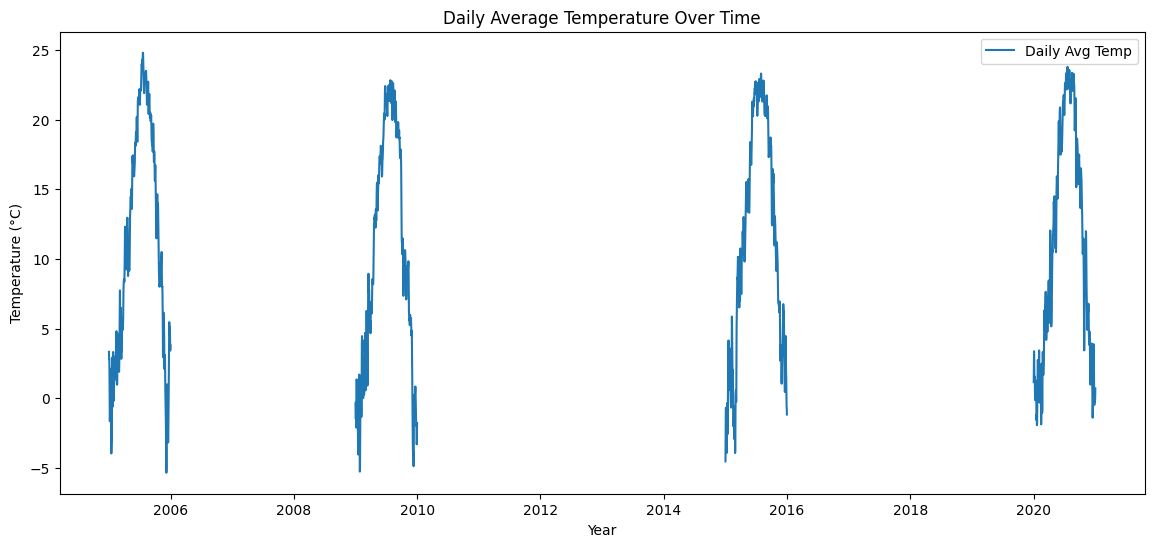

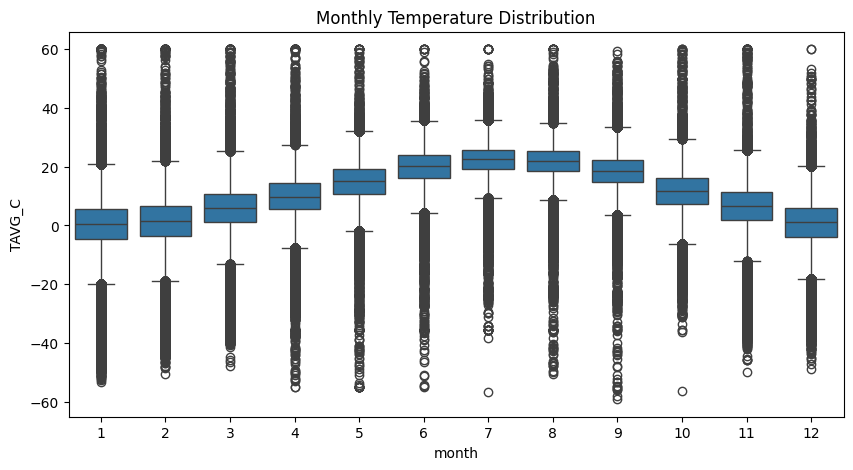

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

print(weather_df.head())
# print(weather_df.describe())
# print(weather_df.isnull().sum())

weather_df['DATE'] = pd.to_datetime(weather_df['DATE'], errors='coerce')
weather_df = weather_df.sort_values('DATE')
weather_df = weather_df.dropna(subset=['DATE'])

if 'YEAR' in weather_df.columns:
    weather_df = weather_df.drop(columns=['YEAR'])

# Create time features
weather_df['year'] = weather_df['DATE'].dt.year
weather_df['month'] = weather_df['DATE'].dt.month

# DATA CLEANING
TEMP_MIN, TEMP_MAX = -60, 60

for col in ['TMAX_C', 'TMIN_C', 'TAVG_C']:
    weather_df[col] = weather_df[col].where(
        weather_df[col].between(TEMP_MIN, TEMP_MAX)
    )

weather_df['PRCP'] = weather_df['PRCP'].clip(lower=0, upper=500)
weather_df['EVAP'] = weather_df['EVAP'].clip(lower=0, upper=100)

numeric_cols = weather_df.select_dtypes(include=[np.number]).columns

weather_df[numeric_cols] = (
    weather_df[numeric_cols]
    .interpolate(method='linear')
)

# DAILY AGGREGATION
df_daily = (
    weather_df
    .set_index('DATE')
    .resample('D')
    .mean(numeric_only=True)
)

# VISUALIZATION
plt.figure(figsize=(14,6))
plt.plot(df_daily.index, df_daily['TAVG_C'], label='Daily Avg Temp')
plt.title("Daily Average Temperature Over Time")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=weather_df['month'], y=weather_df['TAVG_C'])
plt.title("Monthly Temperature Distribution")
plt.show()

# SARIMA TIME SERIES FORECAST
train = df_daily['TAVG_C'][:'2018']
test = df_daily['TAVG_C']['2019':]

train = train.dropna()

df_monthly = (
    weather_df
    .set_index('DATE')
    .resample('M')
    .mean(numeric_only=True)
)

# Keep only months with valid average temperature
df_monthly = df_monthly.dropna(subset=['TAVG_C'])



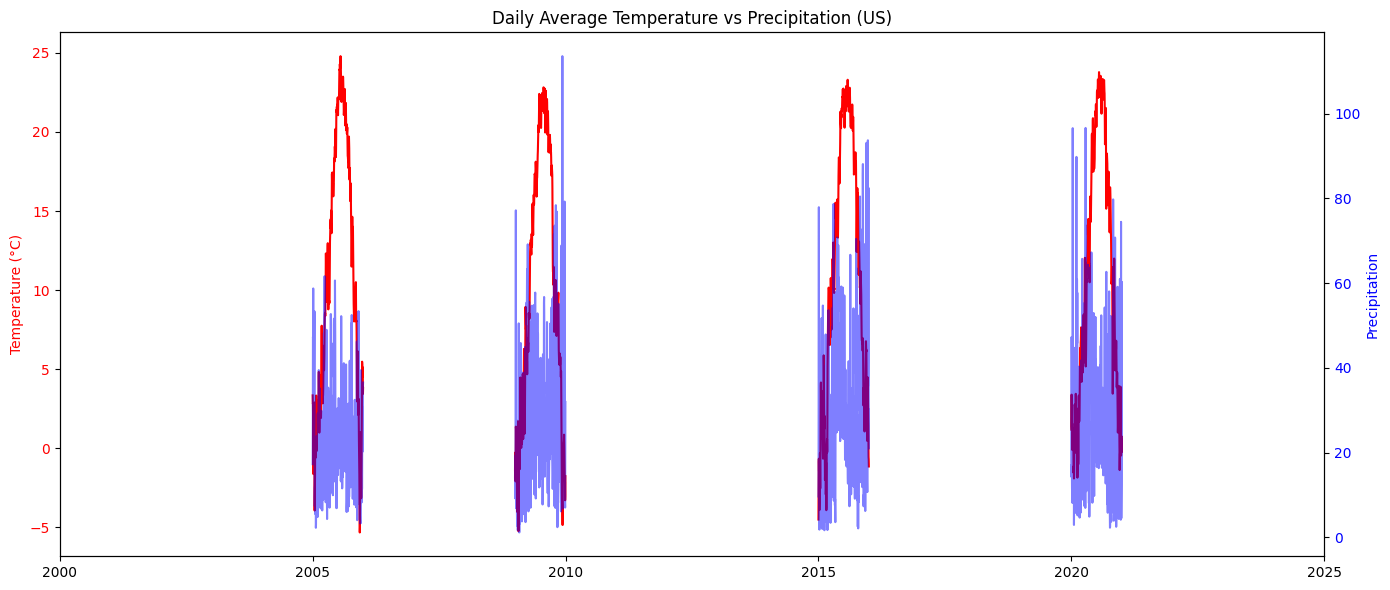

In [ ]:
import matplotlib.dates as mdates

# DAILY TEMPERATURE & PRECIPITATION TRENDS

fig, ax1 = plt.subplots(figsize=(14,6))

# Temperature
ax1.plot(df_daily.index, df_daily['TAVG_C'], color='red', label='Avg Temp (°C)')
ax1.set_ylabel('Temperature (°C)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Precipitation
ax2 = ax1.twinx()
ax2.plot(df_daily.index, df_daily['PRCP'], color='blue', alpha=0.5, label='Precipitation')
ax2.set_ylabel('Precipitation', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

years = [2000, 2005, 2010, 2015, 2020, 2025]
ax1.set_xticks([pd.Timestamp(f"{y}-01-01") for y in years])
ax1.set_xticklabels(years)

plt.title("Daily Average Temperature vs Precipitation (US)")
fig.tight_layout()
plt.show()

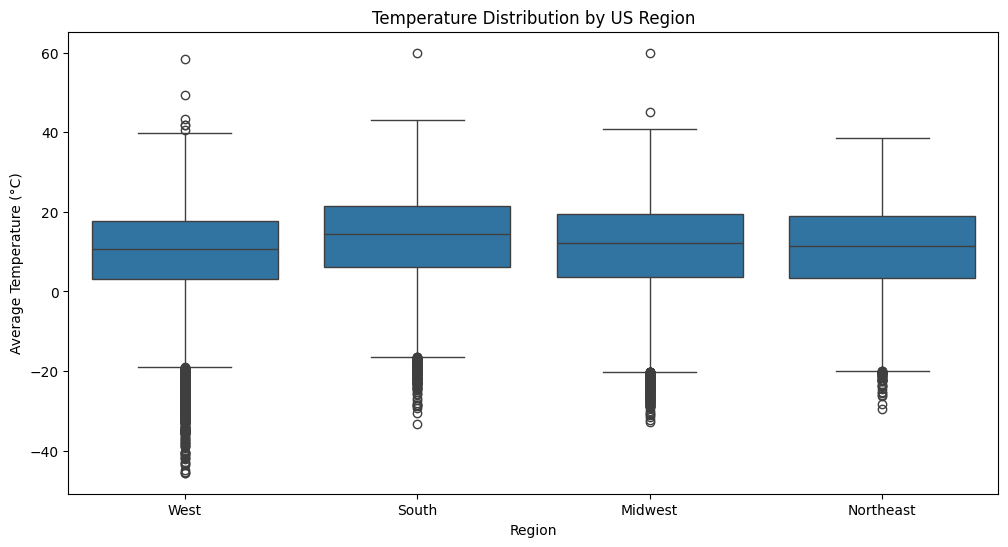

In [ ]:
# REGIONAL TEMPERATURE DISTRIBUTION
plt.figure(figsize=(12,6))
sns.boxplot(
    x='REGION',
    y='TAVG_C',
    data=weather_df.sample(300_000, random_state=42)
)

plt.title("Temperature Distribution by US Region")
plt.xlabel("Region")
plt.ylabel("Average Temperature (°C)")
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


SARIMA MAE: 1.4370557423663124
SARIMA RMSE: 1.902096799177147


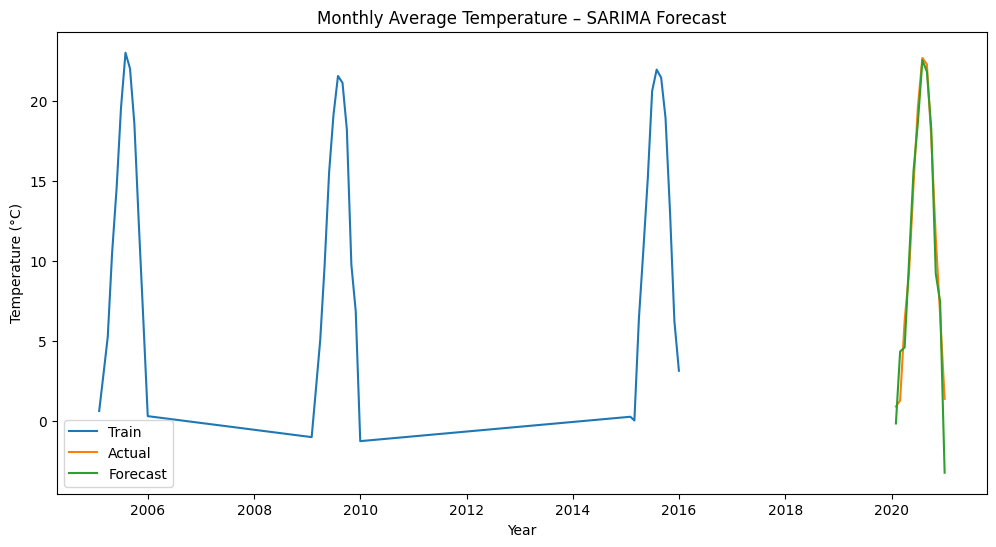

In [ ]:
# SARIMA TIME SERIES FORECAST
train = df_monthly['TAVG_C'][:'2018']
test = df_monthly['TAVG_C']['2019':]

model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = model.fit(disp=False)
forecast = sarima_fit.get_forecast(steps=len(test)).predicted_mean

# SARIMA EVALUATION
print("SARIMA MAE:",
      mean_absolute_error(test, forecast))

print("SARIMA RMSE:",
      np.sqrt(mean_squared_error(test, forecast)))

# SARIMA PLOT
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title("Monthly Average Temperature – SARIMA Forecast")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()


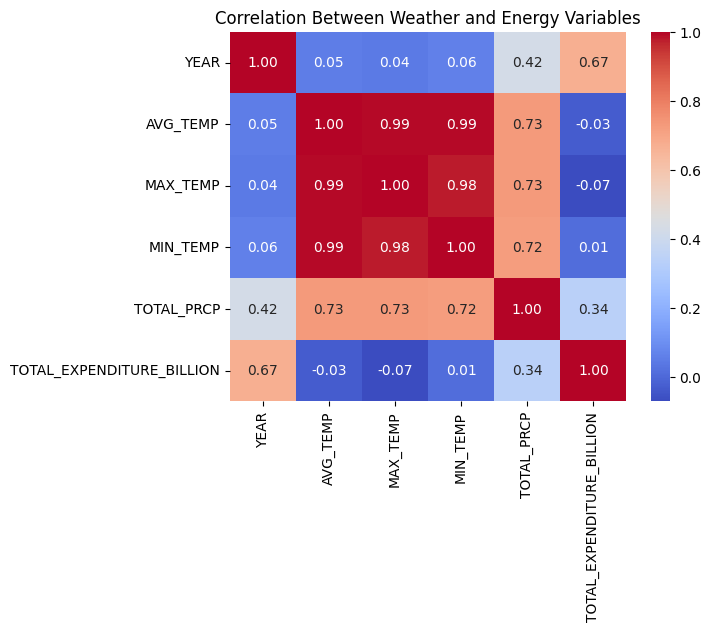

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Keep only numeric columns
numeric_df = combined_df.select_dtypes(include="number")

# Correlation matrix
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Weather and Energy Variables")
plt.show()

K-Means Clustering

In [ ]:
combined_df["ENERGY_PER_HH_MBTU"] = pd.to_numeric(
    combined_df["ENERGY_PER_HH_MBTU"], errors="coerce"
)

combined_df["HOUSEHOLDS_MILLION"] = pd.to_numeric(
    combined_df["HOUSEHOLDS_MILLION"], errors="coerce"
)

# Total energy in TRILLION Btu
combined_df["TOTAL_ENERGY"] = (
    combined_df["ENERGY_PER_HH_MBTU"] * combined_df["HOUSEHOLDS_MILLION"]
)

print(combined_df[["REGION", "YEAR", "TOTAL_ENERGY"]])

       REGION  YEAR  TOTAL_ENERGY
0     Midwest  2005      2905.600
1     Midwest  2009      1282.050
2     Midwest  2015      1092.960
3     Midwest  2020      1306.032
4   Northeast  2005      2517.320
5   Northeast  2009      1054.560
6   Northeast  2015       949.200
7   Northeast  2020      1069.696
8       South  2005      3247.860
9       South  2009      1726.100
10      South  2015      1580.640
11      South  2020      1723.712
12       West  2005      1873.080
13       West  2009      1058.960
14       West  2015       881.760
15       West  2020      1083.852


combined_df        REGION  YEAR   AVG_TEMP   MAX_TEMP   MIN_TEMP   TOTAL_PRCP  \
0     Midwest  2005   9.816376  15.915360   3.716562   21914690.0   
1     Midwest  2009   8.211020  14.102508   2.323742   46987302.0   
2     Midwest  2015   9.689005  15.715528   3.663923   56672793.0   
3     Midwest  2020   9.583826  15.579288   3.594600   53294829.0   
4   Northeast  2005   8.852088  14.492492   3.216023    9607962.0   
5   Northeast  2009   8.175616  13.638296   2.715462   14844495.0   
6   Northeast  2015   8.707966  14.585640   2.827322   16844356.0   
7   Northeast  2020   9.774768  15.309119   4.248129   23369765.0   
8       South  2005  17.038743  23.283127  10.795688   27106231.0   
9       South  2009  16.685558  22.752950  10.620261   78728664.0   
10      South  2015  17.428225  23.370338  11.486265  101387166.0   
11      South  2020  17.460885  23.441858  11.478217  106484389.0   
12       West  2005   9.418444  16.052396   2.789334   26601472.0   
13       West  2009   

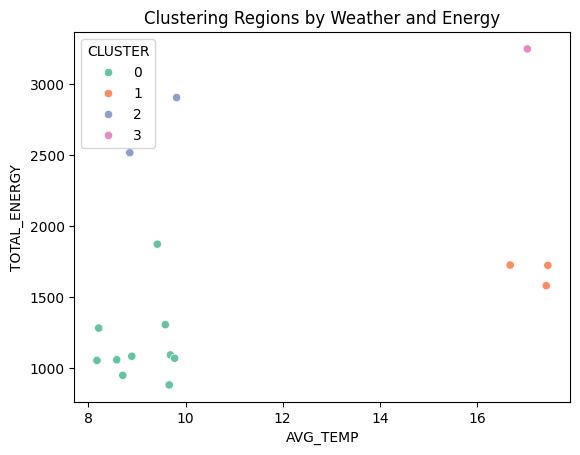

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print('combined_df', combined_df)
print('\ncombined_df', weather_df)
print('weather_region_agg', weather_region_agg)

features = ["AVG_TEMP", "TOTAL_PRCP", "TOTAL_ENERGY"]
X = combined_df[features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
combined_df['CLUSTER'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(data=combined_df, x="AVG_TEMP", y="TOTAL_ENERGY", hue="CLUSTER", palette="Set2")
plt.title("Clustering Regions by Weather and Energy")
plt.show()

Random forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Prepare the dataset
df = combined_df.copy()
df['TOTAL_EXPENDITURE_BILLION'] = df['TOTAL_EXPENDITURE_BILLION'].replace(',', '', regex=True).astype(float)

# Select features and target
features = ['AVG_TEMP', 'MAX_TEMP', 'MIN_TEMP', 'TOTAL_PRCP',
            'ENERGY_PER_HH_MBTU', 'TOTAL_EXPENDITURE_BILLION', 'HOUSEHOLDS_MILLION']
target = 'TOTAL_SITE_ENERGY_QUAD_BTU'

X = df[features]
y = df[target]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Random Forest with hyperparameter tuning
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='r2', random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

best_rf = search.best_estimator_
pred = best_rf.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"Random Forest MAE: {mae:.4f}")
print(f"Random Forest RMSE: {rmse:.4f}")
print(f"Random Forest R²: {r2:.4f}")


Random Forest MAE: 6.5624
Random Forest RMSE: 7.2178
Random Forest R²: 0.8206
